In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import pickle
from timeit import default_timer as timer
import sklearn
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import umap
import seaborn as sns
import matplotlib.cm as cm
import random

from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import mannwhitneyu

# from pysankey import sankey

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering, Birch
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
import igraph
from math import ceil
from timeit import default_timer as timer
import subprocess
from pathlib import Path
from numpy import linalg as LA

import neuro_morpho_toolbox as nmt
import SimpleITK as sitk

from ipywidgets import interactive
import ipywidgets as widgets

# import plotly.plotly as py
# import plotly.offline as po
# import plotly.graph_objs as go

# po.init_notebook_mode(connected=True)

import colorlover as cl
from IPython.display import HTML

bs_child_to_parent = {}

for pid in nmt.bs.selected_regions:
    pname = nmt.bs.level.loc[pid, "Abbreviation"]
    cname = [nmt.bs.level.loc[i, "Abbreviation"] for i in nmt.bs.get_all_child_id(pid)]
    for i in cname:
        bs_child_to_parent[i] = pname
bs_child_to_parent["unknown"] = "unknown"

/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.52
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 1.56


In [49]:
'18869_00024'
ns.features['projection_features'].raw_data.loc['18869_00024'].sort_values(ascending=False).head(10)/1000

ipsi_VAL      6.446557
ipsi_PCN      5.327167
ipsi_CL       2.270241
ipsi_VM       2.256304
ipsi_MD       1.180193
ipsi_SMT      0.849208
contra_CM     0.517436
contra_PCN    0.473733
ipsi_RT       0.442846
contra_SMT    0.429020
Name: 18869_00024, dtype: float64

In [2]:
[ns] = pickle.load(open('./neuron_set_1741cells.pickle', 'rb'))

In [3]:
df = pd.read_csv('/Users/pengxie/Documents/Research/CLA/data/CCF/CellTypes_platform.csv', header=0, index_col=0)
clist = df.index.tolist()
df['My_soma_region'].value_counts()

CLA      34
AId      16
SSs      11
AUD       6
TEa       6
GU        5
VIS       5
SSp       5
MOp       4
ECT       3
VISC      2
MOs       1
VISrl     1
ORBl      1
Name: My_soma_region, dtype: int64

In [4]:
celltype = pd.DataFrame({'Brain_name':df['Brain_id'].tolist(),
                         'Cell_name':df.index.tolist(),
                         'Cell_type':[i.split('_')[0] for i in df['Cell_type'].tolist()],
                         'Sub_type':df['Cell_type'].tolist(),
                         'Soma_region':df['My_soma_region'].tolist()
                        }, index=clist)
celltype.head()

,Brain_name,Cell_name,Cell_type,Sub_type,Soma_region
17109_2401_x9695_y9693,17109,17109_2401_x9695_y9693,CLA,CLA_I-bi,CLA
17109_2601_x10213_y8783,17109,17109_2601_x10213_y8783,CLA,CLA_I-bi,CLA
17109_3101_x10824_y7188,17109,17109_3101_x10824_y7188,CLA,CLA_I-bi,CLA
17109_1701_x8048_y22277,17109,17109_1701_x8048_y22277,pc,pc_bi,AId
17109_1801_x6698_y12550,17109,17109_1801_x6698_y12550,pc,pc_bi,AId


In [5]:
metadata = celltype.copy()

metadata.rename(columns={'Cell_type':'Celltype',
                         'Sub_type':'Subtype'
                        }, inplace=True)
metadata["Bilateral"] = 'unassigned'
for i in metadata.index.tolist():
    if metadata.loc[i, 'Subtype'].endswith('ipsi'):
        metadata.loc[i, 'Bilateral'] = 'Ipsilateral'
    elif metadata.loc[i, 'Subtype'].endswith('bi'):
        metadata.loc[i, 'Bilateral'] = 'Bilateral'

metadata['Bilateral'].value_counts()

Ipsilateral    63
Bilateral      37
Name: Bilateral, dtype: int64

In [6]:
# Unique celltypes and colors
u_subtypes = sorted(list(set(metadata.Subtype)))
celltypes_col = dict(zip(u_subtypes, ["C"+str(i) for i in range(len(u_subtypes))]))

cla_list = metadata.index.tolist()
print("Number of cells from CLA project : %d" % len(cla_list))


Number of cells from CLA project : 100


In [7]:
def sum_regions(x, region='SSp'):
    for tag in ['ipsi_', 'contra_']:
        tp_list = [tag+nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id(region)]
        tp_list = [i for i in tp_list if i in (x.columns.tolist())]
        res = x[tp_list].sum(axis=1)
        x.drop(columns=tp_list, inplace=True)
        x[tag+region] = res
        print(len(tp_list))
    return x

In [45]:
projection_df_full = ns.features['projection_features'].raw_data.copy().loc[clist] / 1000
projection_df_full = sum_regions(projection_df_full, 'SSp')
projection_df = projection_df_full.drop(columns=['ipsi_fiber tracts', 'contra_fiber tracts'], inplace=False)

thres_mm = 1
# thres = np.log(thres_mm+1)
# use_features = projection_df.columns[np.sum(projection_df>thres)>=5]
use_features = projection_df.columns[np.sum(projection_df>thres_mm)>3].tolist()
# use_features = projection_df.columns[np.sum(projection_df>thres_mm)>=5].tolist()
for i in ['ipsi_CP', 'contra_CP']:
    if i in use_features:
        use_features.remove(i)
projection_df = projection_df[use_features]
projection_df.shape

7
7


(100, 63)

In [30]:
alength = pd.DataFrame(projection_df_full.sum(axis=1), columns=['axon_length'])
alength['celltype'] = celltype.loc[alength.index, 'Cell_type']
alength.head()

,axon_length,celltype
17109_2401_x9695_y9693,80.649337,CLA
17109_2601_x10213_y8783,99.090599,CLA
17109_3101_x10824_y7188,101.178644,CLA
17109_1701_x8048_y22277,70.163678,pc
17109_1801_x6698_y12550,151.061649,pc


In [31]:
clist1 = alength[alength['celltype']=='CLA'].index.tolist()
clist2 = alength[alength['celltype']=='pc'].index.tolist()

tlist = clist1
mu = np.mean(alength.loc[tlist, 'axon_length'])
sem = np.std(alength.loc[tlist, 'axon_length']) / np.sqrt(len(tlist))
print(mu, sem)

tlist = clist2
mu = np.mean(alength.loc[tlist, 'axon_length'])
sem = np.std(alength.loc[tlist, 'axon_length']) / np.sqrt(len(tlist))
print(mu, sem)


mannwhitneyu(alength.loc[clist1, 'axon_length'], alength.loc[clist2, 'axon_length'])

134.08078021487987 8.666040837095625
105.2216626045045 5.139557053934349


MannwhitneyuResult(statistic=749.0, pvalue=0.0045314825436471055)

## Are there subcortical projections?

In [44]:
tlist = []
ctx_list = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('Isocortex')]
for i in projection_df_full.columns.tolist():
    j = i.replace('ipsi_', '').replace('contra_', '')
    if j in ctx_list:
        continue
    tlist.append(i)
tp = projection_df_full.loc[clist1, tlist].copy()>1
tp = tp.sum(axis=0)
tp.sort_values(ascending=False).head(10)

ipsi_fiber tracts      30
ipsi_CP                24
ipsi_ENTl              22
ipsi_CLA               19
ipsi_ENTm              17
ipsi_EPd               13
ipsi_PAR                7
ipsi_POST               7
contra_fiber tracts     6
ipsi_SUB                4
dtype: int64

In [47]:
tlist = []
ctx_list = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('Isocortex')]
for i in projection_df.columns.tolist():
    j = i.replace('ipsi_', '').replace('contra_', '')
    if j in ctx_list:
        continue
    tlist.append(i)
tp = projection_df.loc[clist1, tlist].copy()>1
tp = tp.sum(axis=0)
tp.sort_values(ascending=False).head(20)

ipsi_ENTl    22
ipsi_CLA     19
ipsi_ENTm    17
ipsi_EPd     13
ipsi_POST     7
ipsi_PAR      7
ipsi_SUB      4
ipsi_BLA      3
ipsi_LA       2
dtype: int64

In [ ]:
tlist = []
ctx_list = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('Isocortex')]
for i in projection_df_full.columns.tolist():
    j = i.replace('ipsi_', '').replace('contra_', '')
    if j in ctx_list:
        continue
    tlist.append(i)
tp = projection_df_full.loc[clist1, tlist].copy()>1
tp = tp.sum(axis=0)
tp.sort_values(ascending=False).head(10)

In [43]:
'BLA' in ctx_list

True

In [42]:
tp = projection_df_full.loc[clist2, ['ipsi_LA', 'ipsi_BLA', 'ipsi_BMA']].copy()
tp[(tp>0).any(axis=1)]

,ipsi_LA,ipsi_BLA,ipsi_BMA
236174_6338_x12092_y5845,2.633866,1.568699,0.000000
236174_6438_x12218_y5897,3.519376,6.645178,0.486336
236174_6855_x15550_y29832,12.149224,12.247007,0.428219


In [12]:
soma_df = ns.features['soma_features'].raw_data.copy().loc[clist][['x', 'y', 'z']]
# # projection_df = ns.features['projection_features'].scaled_data.copy().loc[clist]

# # use_features = projection_df.columns[np.sum(projection_df>np.log(100))>=3]
# # projection_df = projection_df[use_features]

# projection_df = ns.features['projection_features'].raw_data.copy().loc[clist]/1000

# use_features = projection_df.columns[np.sum(projection_df>1)>=3]
# projection_df = projection_df[use_features]


In [13]:
lm_feature_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/features/'

In [14]:
def outlier(df, k_sigma = 5):   
    sigma = df.std(axis=0)
    mu = df.mean(axis=0)
    low_bound = np.array(mu - sigma*k_sigma).reshape(1,-1)
    high_bound = np.array(mu + sigma*k_sigma).reshape(1,-1)
    res = df[((df<low_bound) | (df>high_bound)).any(axis=1)]
    flist = ((df<low_bound) | (df>high_bound)).any(axis=0)
    flist = flist[flist].index.tolist()
    bound = pd.DataFrame({'lower bound':list(low_bound.reshape(-1,)),
                          'upper bound':list(high_bound.reshape(-1))
                         }, index=df.columns).transpose().round(2)
    res = res[flist]
    bound = bound[flist]
    return res, bound
#     return flist, bound


use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcatons', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]

df = pd.read_csv(lm_feature_path + "dendrite.features", 
                 header=[0], index_col=[0], delimiter="\t").transpose()

df = df.loc[clist, use_cols]



res, bound = outlier(df)
res

ID,Overall Width,Max Euclidean Distance
17781_6202_x7633_y12296,3238.6,3136.2


In [15]:
use_cols = [#'Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 
            'Max Path Distance', 
#             'Number of Bifurcatons', 
#             'Number of Tips', 
            'Number of Branches', 
#             'Max Branch Order',
#             'Average Contraction', 
#             'Average Fragmentation',
#             'Average Bifurcation Angle Local', 
#             'Average Bifurcation Angle Remote', 
#             'Hausdorff Dimension'
           ]
df = pd.read_csv(lm_feature_path + "axon.features", 
                 header=[0], index_col=[0], delimiter="\t").transpose()
df = df.loc[clist, use_cols]

res, bound = outlier(df)
if len(res)>0:
    print("Warning: outlier found...")

lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

# pickle.dump([lm_axon], open("features_lm_axon_CLA.pickle", "wb"))

Number of input neurons: 100
Number of input features: 7


Number of Tips vs. Number of Bifurcatons
Number of input neurons: 100
Number of input features: 8


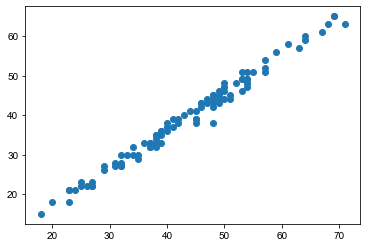

In [16]:
# Non-repeated features
use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcatons', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]

df = pd.read_csv(lm_feature_path + "dendrite.features", 
                 header=[0], index_col=[0], delimiter="\t").transpose()

df = df.loc[clist, use_cols]
# Outlier
df.loc['17781_6202_x7633_y12296', ['Overall Width', 'Overall Height', 'Overall Depth', 'Max Euclidean Distance', ]] = [286.107, 221.17, 204.117, 224.247]


# Check whether any highly correlated features

tp = df.transpose()
cc = np.corrcoef(tp)
a, b = np.where(cc>0.95)
for i in range(len(a)):
    if a[i] > b[i]:
        print("%s vs. %s" % (tp.index[a[i]], tp.index[b[i]]))
        plt.scatter(tp.loc[tp.index[a[i]]], tp.loc[tp.index[b[i]]])
        
use_cols = [
#     'Number of Stems', 
    'Overall Width', 'Overall Height', 'Overall Depth', 
    'Total Length',
    'Max Euclidean Distance', 'Max Path Distance', 
#     'Number of Bifurcatons', 
    'Number of Branches', 
#     'Number of Tips',
    'Max Branch Order',
#     'Average Contraction', 'Average Fragmentation',
#     'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
#     'Hausdorff Dimension'
]

df = df[use_cols]
res, bound = outlier(df)
if len(res)>0:
    print("Warning: outlier found...")

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)
# pickle.dump([lm_dendrite], open("features_lm_dendrite_CLA.pickle", "wb"))


In [17]:
# Non-repeated features
use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcatons', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]

df = pd.read_csv(lm_feature_path + "proximal_axon.features", 
                 header=[0], index_col=[0], delimiter="\t").transpose()
df = df.loc[clist, use_cols]

use_cols = [#'Number of Stems', 
#             'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
#             'Max Euclidean Distance', 'Max Path Distance', 
#             'Number of Bifurcatons', 
#             'Number of Tips', 
            'Number of Branches', 
#             'Max Branch Order',
#             'Average Contraction', 
#             'Average Fragmentation',
#             'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
#             'Hausdorff Dimension'
           ]

df = df[use_cols]
res, bound = outlier(df)
if len(res)>0:
    print("Warning: outlier found...")

lm_local_axon = nmt.features("L-measure of local axon")
lm_local_axon.add_raw_data(df)
# pickle.dump([lm_local_axon], open("features_lm_local_axon_CLA.pickle", "wb"))

Number of input neurons: 100
Number of input features: 2


In [18]:
pickle.dump([metadata,
             soma_df,
             projection_df,
             lm_dendrite,
             lm_axon,
             lm_local_axon
            ], open("features_CLA_axon_length.pickle", "wb"))